## This file is used to realized the CAE(covolutional autoencoder)
- 1.data I/O for fibracatal surface
- 2.define cae model for surface reconstruction
- 3.train model
- 4.Test model and plot results
ref:[blog](https://pgaleone.eu/neural-networks/2016/11/24/convolutional-autoencoders/),[code1](https://www.jianshu.com/p/f34842a3b19a),[code2](https://zhuanlan.zhihu.com/p/27902193)

In [1]:
import os 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np
import time
import cv2

#### 1. Make .tfrecords files for high efficency I/O

In [2]:
def rec_fun(path,rec_name):
    #path = 'surface/'    #where you store your data
    #classes = {'img_ter/train'}    #setting the classes
    classes = {path}
    writer= tf.python_io.TFRecordWriter(rec_name) #initialize a writer to record

    for index,name in enumerate(classes):
        #class_path=path+name+'/'
        class_path = name+'/'
        for img_name in os.listdir(class_path): 
            if img_name.endswith('.jpg'):
                #print(img_name)
                img_path=class_path+img_name #每一个图片的地址
                img=cv2.imread(img_path,0)
                #print(img.shape)
                #img= img.resize((28,28))
                #print(type(img))
                img_raw=img.tobytes()#将图片转化为二进制格式
                example = tf.train.Example(features=tf.train.Features(feature={
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[index])),
                'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw]))
                })) #example对象对label和image数据进行封装
                writer.write(example.SerializeToString())  #序列化为字符串

    writer.close()
    #https://www.2cto.com/kf/201702/604326.html

In [51]:
#save training and valid folder and as records
rec_fun('img_ter/train',"surface_ter_train.tfrecords")
rec_fun('img_ter/valid',"surface_ter_valid.tfrecords")

#### 2. Read .tfrecords file into iter

In [2]:
#defined function to read data from .rec to data iter
#https://blog.csdn.net/qwe2508/article/details/80680640
def read_and_decode(file_name,batch_size = 32,shuffle=True):
    def parser(record):
        features = tf.parse_single_example(record,
                                           features={
                                               'label': tf.FixedLenFeature([], tf.int64),
                                               'img_raw': tf.FixedLenFeature([], tf.string),
                                           })  # return image and label
        image = tf.decode_raw(features['img_raw'], tf.uint8)
        img = tf.reshape(image, [128, 128, 1])    #caution the dimesion size
        img = tf.cast(img, tf.float32) * (1. / 255)   #normalized
        #img = tf.image.per_image_standardization(img)  #standarize:(x - mean) / adjusted_stddev
        #this is not normalization, but standardazation.https://blog.csdn.net/sinat_21585785/article/details/74251563
        #normalization is very important for loss converge
        img = tf.cast(img, tf.float32)
        '''
        # random augmentation
        image_size = 28
        height = image_size
        width = image_size
        # Randomly crop a [height, width] section of the image.随机裁剪
        distorted_image = tf.random_crop(img, [height, width, 1])
        # Randomly flip the image horizontally.随机翻转
        distorted_image = tf.image.random_flip_left_right \
            (distorted_image)
        # 改变亮度
        distorted_image = tf.image.random_brightness(distorted_image,
                                                     max_delta=63)
        # 改变对比度
        distorted_image = tf.image.random_contrast(distorted_image,
                                                   lower=0.2, upper=1.8)
        img = tf.image.per_image_standardization(distorted_image)
        '''
        label = tf.cast(features['label'], tf.int32)
        return img,label
    
    #batch_size = 256
    dataset = tf.data.TFRecordDataset(file_name)
    if shuffle:
        dataset = dataset.map(parser,num_parallel_calls=4).repeat().batch(batch_size).shuffle(buffer_size=1000)
    else:
        dataset = dataset.map(parser,4).repeat().batch(batch_size)

    iterator = dataset.make_one_shot_iterator()

    img_input, label = iterator.get_next()
    return img_input,label

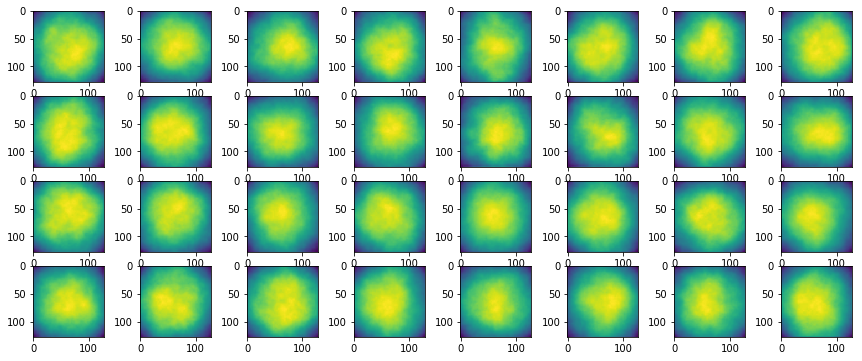

1.0


In [4]:
#Display data, check the format and value region
images_train, labels_train = read_and_decode('surface_ter_train.tfrecords')
with tf.Session() as sess:
    for i in range(2):
        imgs = sess.run(images_train)
#        print(imgs.shape)
#        plt.imshow(imgs[0].reshape((28,28)))
#        break
        f, a = plt.subplots(4, 8, figsize=(15, 6))
        #f.suptitle('h1 = %d,h2=%d,h3=%d,epochs is %d, RMSE is %f'%(n_hidden_1,n_hidden_2,n_hidden_3,training_epochs,RMSE), fontsize=16)
        for i in range(8):
            a[0][i].imshow(np.reshape(imgs[4*i], (128, 128)))
            a[1][i].imshow(np.reshape(imgs[4*i+1], (128, 128)))
            a[2][i].imshow(np.reshape(imgs[4*i+2],(128,128)))
            a[3][i].imshow(np.reshape(imgs[4*i+3],(128,128)))
        #plt.savefig("%d_%d_%d_001_%d_RMSE.png"%(n_hidden_1,n_hidden_2,n_hidden_3,training_epochs))    #要在show前调用
        plt.show()
        print(imgs[i].reshape((128,128)).max())    #check the max value
        break
    
#show some examples and get the max values

#### 3.Define model

In [3]:
#define model
#This model is a simple demo, with 6 layers structures
input_size = 128
inputs_ = tf.placeholder(tf.float32,(None, input_size, input_size, 1), name='inputs_')
targets_ = tf.placeholder(tf.float32,(None, input_size, input_size, 1), name='targets_')

#define encoder
conv1 = tf.layers.conv2d(inputs_, 64,(3,3), padding='same', activation=tf.nn.relu)
conv1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')    #stride & size 2*2
#out input_size/2*input_size/2*64

conv2 = tf.layers.conv2d(conv1, 128,(3,3), padding='same', activation=tf.nn.relu)
conv2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
#out input_size/4*input_size/4*128

conv3 = tf.layers.conv2d(conv2, 256,(3,3), padding='same', activation=tf.nn.relu)
conv3 = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
#out input_size/8*input_size/8*256

#defin deconder， here need up sampling
conv4 = tf.image.resize_nearest_neighbor(conv3,(int(input_size/4),int(input_size/4)))
conv4 = tf.layers.conv2d(conv4, 128,(3,3), padding='same', activation=tf.nn.relu)
#out input_size/4*input_size/4*128

conv5 = tf.image.resize_nearest_neighbor(conv4, (int(input_size/2), int(input_size/2)))
conv5 = tf.layers.conv2d(conv4, 64, (3,3), padding='same', activation=tf.nn.relu) 
#out input_size/2*input_size/2*64

conv6 = tf.image.resize_nearest_neighbor(conv5,(input_size,input_size))
conv6 = tf.layers.conv2d(conv6, 64, (3,3), padding='same', activation=tf.nn.relu)
#out input_size*input_size*64

#output = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=tf.nn.relu)
#logits_ = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)

In [4]:
#setting loss and optimizer
logits_ = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#outputs_ = tf.nn.sigmoid(logits_, name='outputs_')
#loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits_)
#cost = tf.reduce_mean(loss)
cost = tf.reduce_mean(tf.pow(logits_ - targets_, 2)) #最小二乘法

#change lr
learning_rate = 0.01
current_iter = tf.Variable(0); 
decay_steps = 30                 #每一步衰减一次,if too small to can't stable
decay_rate = 0.997
lr = tf.train.exponential_decay(learning_rate,current_iter,decay_steps,decay_rate) #for decay
#Definition:
optimizer = tf.train.AdamOptimizer(lr).minimize(cost,current_iter) 
#optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)
sess = tf.Session()

In [5]:
#setting params
epochs = 200
batch_size = 64
total_batch = int(9000/batch_size) #总批数
images_train, labels_train = read_and_decode('surface_ter_train.tfrecords',
                                             batch_size = batch_size)
sess.run(tf.global_variables_initializer())

#### 4. Training

Training is begining~~~~
8192 images is processed
Epoch: 1/200  Training loss: 0.0056 Time: 34.5687seconds
8192 images is processed
Epoch: 2/200  Training loss: 0.0010 Time: 30.6610seconds
8192 images is processed
Epoch: 3/200  Training loss: 0.0007 Time: 30.6617seconds
8192 images is processed
Epoch: 4/200  Training loss: 0.0006 Time: 30.7215seconds
8192 images is processed
Epoch: 5/200  Training loss: 0.0004 Time: 30.7544seconds
8192 images is processed
Epoch: 6/200  Training loss: 0.0003 Time: 30.7376seconds
8192 images is processed
Epoch: 7/200  Training loss: 0.0003 Time: 30.8189seconds
8192 images is processed
Epoch: 8/200  Training loss: 0.0002 Time: 30.8068seconds
8192 images is processed
Epoch: 9/200  Training loss: 0.0005 Time: 30.8771seconds
8192 images is processed
Epoch: 10/200  Training loss: 0.0002 Time: 30.8797seconds
8192 images is processed
Epoch: 11/200  Training loss: 0.0003 Time: 30.8220seconds
8192 images is processed
Epoch: 12/200  Training loss: 0.0002 Time: 30.

8192 images is processed
Epoch: 100/200  Training loss: 0.0000 Time: 30.9541seconds
8192 images is processed
Epoch: 101/200  Training loss: 0.0001 Time: 30.9415seconds
8192 images is processed
Epoch: 102/200  Training loss: 0.0001 Time: 30.9284seconds
8192 images is processed
Epoch: 103/200  Training loss: 0.0001 Time: 30.9972seconds
8192 images is processed
Epoch: 104/200  Training loss: 0.0001 Time: 31.0059seconds
8192 images is processed
Epoch: 105/200  Training loss: 0.0001 Time: 31.0249seconds
8192 images is processed
Epoch: 106/200  Training loss: 0.0001 Time: 30.9845seconds
8192 images is processed
Epoch: 107/200  Training loss: 0.0001 Time: 30.9165seconds
8192 images is processed
Epoch: 108/200  Training loss: 0.0001 Time: 30.9359seconds
8192 images is processed
Epoch: 109/200  Training loss: 0.0001 Time: 30.9214seconds
8192 images is processed
Epoch: 110/200  Training loss: 0.0002 Time: 30.9681seconds
8192 images is processed
Epoch: 111/200  Training loss: 0.0000 Time: 30.9403

8192 images is processed
Epoch: 198/200  Training loss: 0.0000 Time: 30.9624seconds
8192 images is processed
Epoch: 199/200  Training loss: 0.0000 Time: 30.9590seconds
8192 images is processed
Epoch: 200/200  Training loss: 0.0000 Time: 30.9490seconds


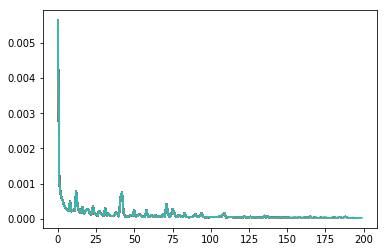

In [6]:
#Training process
print("Training is begining~~~~")
train_loss=[]
for e in range(epochs):
    count=0
    tic = time.time()
    for idx in range(total_batch):
        batch_xs = sess.run(images_train)
        batch_xs = batch_xs.reshape((-1, 128, 128, 1))
        
        batch_cost, _ = sess.run([cost, optimizer],
                           feed_dict={inputs_: batch_xs,
                                     targets_: batch_xs})
        del batch_xs
        count+=1
        
        if count==128:
            print("%d images is processed"%(batch_size*count))
    train_loss.append(batch_cost)        
    toc = time.time() 
    print("Epoch: {}/{} ".format(e+1, epochs),
             "Training loss: {:.4f}".format(batch_cost),"Time: {:.4f}seconds".format(toc-tic))
    plt.plot(train_loss)
    plt.savefig('train_cae_loss.png')

#### 5.Prediction

RMSE is  0.005615317055798892
PV values is 0.022937328
PV values is 0.018411756
PV values is 0.028741956
PV values is 0.02376777
PV values is 0.028658152
PV values is 0.034020722
PV values is 0.026425093
PV values is 0.025871515
PV values is 0.021045506
PV values is 0.043224454


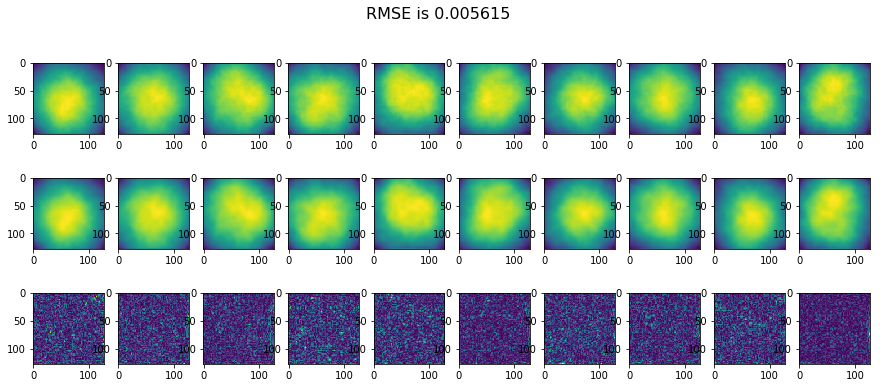

In [7]:
####################################################################################
#测试和计算结果，这里馈入数据十个
n_input=input_size*input_size
examples_to_show = 10

images_valid, labels_valid = read_and_decode('surface_ter_valid.tfrecords',batch_size=batch_size)
batch_xs = sess.run(images_valid)
batch_xs = batch_xs.reshape((-1,128, 128, 1))
#encode_decode = sess.run(y_pred, feed_dict={X: batch_xs,keep_prob:1})
encode_decode = sess.run(logits_, feed_dict={inputs_: batch_xs})    
#print(encode_decode.shape)
#计算均方根值
ERR = 0    #图与图之间的整体误差
for i in range(examples_to_show):
    err_img = batch_xs[i]-encode_decode[i]
    err_img = err_img**2
    err_sqrt = np.sqrt(err_img.sum()/n_input)
    #print("err is",err_sqrt)

    #计算总误差
    ERR = err_sqrt + ERR
    #RMSE = ERR/(100*examples_to_show)    #100 was intro by more items
RMSE = ERR/(examples_to_show)

print("RMSE is ",RMSE)    #计算平均RMES


#选出十个指标用于显示
f, a = plt.subplots(3, 10, figsize=(15, 6))
f.suptitle('RMSE is %f'%(RMSE), fontsize=16)
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(batch_xs[i], (128, 128)))
    a[1][i].imshow(np.reshape(encode_decode[i], (128, 128)))
    a[2][i].imshow(np.reshape(np.abs((batch_xs[i]-encode_decode[i])),(128,128)))
    print('PV values is',(batch_xs[i]-encode_decode[i]).max())
plt.savefig("CAE_%d_RMSE.png"%(epochs))    #要在show前调用
plt.show()

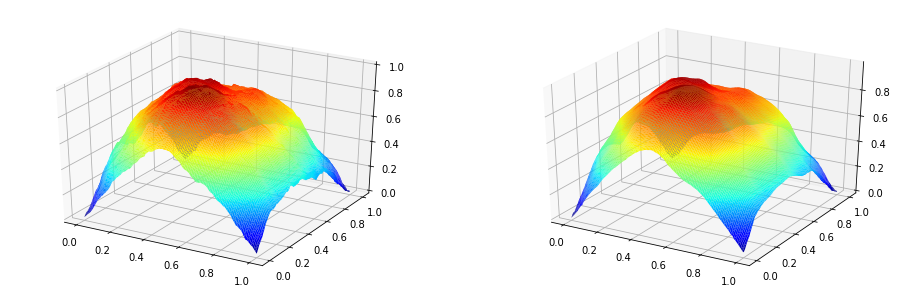

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(0,1,128)
y = np.linspace(0,1,128)
X, Y = np.meshgrid(x, y)#XY平面的网格数据

fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121, projection='3d')
Z = batch_xs[i].reshape([128,128])
ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap=plt.cm.jet,edgecolor='none',shade='interp')
ax = fig.add_subplot(122, projection='3d')
Z = encode_decode[i].reshape([128,128])
ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap=plt.cm.jet,edgecolor='none',shade='interp')   

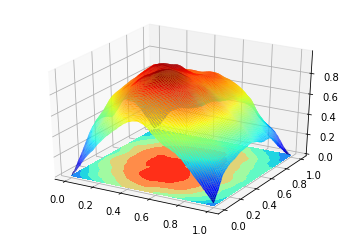

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap=plt.cm.jet,edgecolor='none',shade='interp')
ax.contourf(X,Y,Z,zdir='z',offset=0,cmap='rainbow') #zdir= x/y/x 轴的等高线 offset=等高线的位置
plt.show()

In [ ]:
#This parts could save weights into .ckpt
#saver = tf.train.Saver()
#save_path = saver.save(sess, "./results/paramters/cae_167.ckpt")
#print(save_path)